In [15]:
import tensorflow as tf
import keras
import os
import cv2
import numpy as np

In [16]:
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images=[]
for im in os.listdir('cats/'):
    image=cv2.imread('cats/'+im)
    try:
        image = (image - 127.5) / 127.5
        train_images.append(image)
    except:
        pass


In [17]:
#train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images=np.array(train_images)

In [76]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 16

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [77]:
train_images.shape

(15747, 64, 64, 3)

In [78]:
from tensorflow.keras import layers

def generator_model():
    model=tf.keras.Sequential()
    model.add(layers.InputLayer((100,)))
    model.add(layers.Dense(8*8*512, use_bias=False))
    model.add(layers.Reshape((8, 8, 512)))
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(32, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, kernel_size=(5,5), strides=(1,1), padding='same', activation='tanh'))

    return model



In [79]:
generator=generator_model()

In [80]:
generator.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 32768)             3276800   
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 16, 16, 128)      1638528   
 ranspose)                                                       
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 32, 32, 64)       204864    
 ranspose)                                                       
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 32, 32, 64)      

In [157]:

from keras.applications.resnet import ResNet50

def discriminator_model():
    model=keras.Sequential()
    model.add(ResNet50(include_top=False, weights='imagenet', input_shape=(64, 64, 3)))
    #model.add(layers.InputLayer((64, 64, 3)))
    # model.add(layers.Conv2D(32, kernel_size=(5,5), strides=(2,2), padding='same'))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))
    # model.add(layers.Conv2D(64, kernel_size=(5,5), strides=(2,2), padding='same'))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))
    # model.add(layers.Conv2D(128, kernel_size=(5,5), strides=(2,2), padding='same'))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(64))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))
    return model


In [158]:
discriminator = discriminator_model()
#discriminator.layers[0].trainable = False
print([l.trainable for l in discriminator.layers])

[True, True, True, True, True]


In [159]:
discriminator.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_12 (Flatten)        (None, 8192)              0         
                                                                 
 dense_20 (Dense)            (None, 64)                524352    
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 24,112,129
Trainable params: 24,059,009
Non-trainable params: 53,120
_________________________________________________________________


In [160]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [161]:
def discriminator_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real), real)
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)

In [162]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [163]:
EPOCHS = 50
noise_dim = 100

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real= discriminator(images, training=True)
        fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake)
        disc_loss = discriminator_loss(real, fake)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [164]:
def train(dataset, epochs):
      for epoch in range(epochs):
        print(epoch)
        for image_batch in dataset:
            train_step(image_batch)

In [165]:
train(train_dataset, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


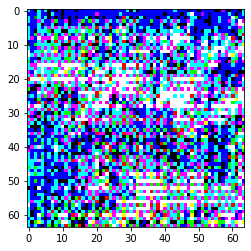

In [190]:
import matplotlib.pyplot as plt

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
im = generated_image[0, :, :, :]
#im = np.array(((generated_image[0, :, :, :]*127.5)+127.5)).astype(int)
plt.imshow(im)